<a href="https://www.kaggle.com/code/sergeyche/shoesclassification?scriptVersionId=105196526" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.losses import CategoricalCrossentropy 
from tensorflow.image import rgb_to_grayscale 
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.inception_v3 import InceptionV3 

In [2]:
PATH = '../input/nike-adidas-and-converse-imaged'
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'
BATCH_SIZE = 16
train_dir = f'{PATH}/{TRAIN_PATH}'
test_dir = f'{PATH}/{TEST_PATH}'

In [3]:
# define names of the classes 
CLASSES = [shoes_label for shoes_label in sorted(os.listdir(f'{PATH}/{TRAIN_PATH}'))]
CLASSES

['adidas', 'converse', 'nike']

### Let's define a function for show random image

In [4]:
def show_random_image(target_dir=f'{PATH}/{TRAIN_PATH}', target_class=random.choice(CLASSES)):
  # setting up the image directory
  target_folder = target_dir + target_class

  #get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #read image and plotting it
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  
  return img

## Show random image

Image shape: (240, 240, 3)
Image shape: (240, 240, 3)
Image shape: (240, 240, 3)


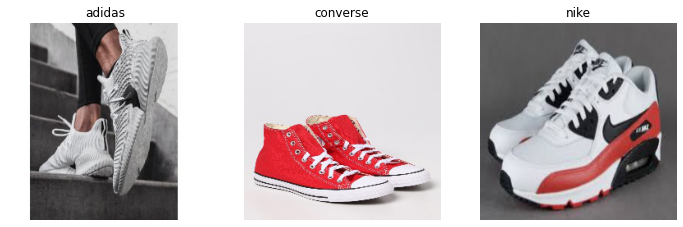

In [5]:
plt.figure(figsize=(12, 7))
plt.subplot(1,3,1)
img = show_random_image(target_class='adidas')
plt.subplot(1,3,2)
img = show_random_image(target_class='converse')
plt.subplot(1,3,3)
img = show_random_image(target_class='nike')

## Define Image Augmentation functions

In [6]:
# Images for train will be random modification
train_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=30,
)
# Images for test just will scale
test_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_generator.flow_from_directory(
    directory=train_dir,
    batch_size=BATCH_SIZE,
    target_size=(240, 240),
    class_mode='categorical'
)

test_generator = test_generator.flow_from_directory(
    directory=test_dir,
    batch_size=BATCH_SIZE,
    target_size=(240, 240),
    class_mode='categorical'
)

Found 711 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


## Service function for draw plot

In [7]:
def bar_plotting(history):
  plt.figure(figsize=(13, 7))
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], label='Train loss')
  plt.plot(history['val_loss'], label='Val loss')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], label='Train acc')
  plt.plot(history['val_accuracy'], label='Val acc')
  plt.legend()
  plt.show()## Service function for draw plot

## Simple Convolutional NN

In [8]:
# Simple CNN 
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3, 3))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3, 3))
model.add(layers.Conv2D(256, (2, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(len(CLASSES), activation='softmax'))

model.compile(
    loss=CategoricalCrossentropy(),
    metrics='accuracy',
    optimizer=Adam(learning_rate=0.001),
    run_eagerly=True
)

2022-09-08 09:51:44.259648: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
).history

2022-09-08 09:51:45.864974: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
45/45 [==============================] - 72s 2s/step - loss: 1.3229 - accuracy: 0.3390 - val_loss: 1.0943 - val_accuracy: 0.3860
Epoch 2/10
45/45 [==============================] - 72s 2s/step - loss: 1.1031 - accuracy: 0.3783 - val_loss: 1.0923 - val_accuracy: 0.4737
Epoch 3/10
45/45 [==============================] - 71s 2s/step - loss: 1.1013 - accuracy: 0.3980 - val_loss: 1.0943 - val_accuracy: 0.3333
Epoch 4/10
45/45 [==============================] - 70s 2s/step - loss: 1.0849 - accuracy: 0.3643 - val_loss: 1.0979 - val_accuracy: 0.3509
Epoch 5/10
45/45 [==============================] - 71s 2s/step - loss: 1.0867 - accuracy: 0.4149 - val_loss: 1.0804 - val_accuracy: 0.4211
Epoch 6/10
45/45 [==============================] - 70s 2s/step - loss: 1.0825 - accuracy: 0.3797 - val_loss: 1.0885 - val_accuracy: 0.4211
Epoch 7/10
45/45 [==============================] - 71s 2s/step - loss: 1.0640 - accuracy: 0.4121 - val_loss: 1.0664 - val_accuracy: 0.4298
Epoch 8/10
45/45 [==

## Model with pre trained InceptionV3

In [10]:
inception = InceptionV3(
    include_top=False,
    input_shape=(300, 300, 3)
)
# Don't correct Inception weights
inception.trainable = False
# To base model we append a few layers...
model = models.Sequential([
    inception,
    # including average pool by channels
    layers.GlobalAveragePooling2D(),
    # and output neurons for 3 classes
    layers.Dense(len(CLASSES), activation='softmax')
])

model.compile(
    loss=CategoricalCrossentropy(),
    metrics='accuracy',
    optimizer=Adam(learning_rate=0.001)
)

87924736/87910968 [==============================] - 0s 0us/step


In [11]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
).history

Epoch 1/10
45/45 [==============================] - 69s 1s/step - loss: 1.0326 - accuracy: 0.4923 - val_loss: 0.8304 - val_accuracy: 0.6404
Epoch 2/10
45/45 [==============================] - 61s 1s/step - loss: 0.8153 - accuracy: 0.6259 - val_loss: 0.7253 - val_accuracy: 0.7018
Epoch 3/10
45/45 [==============================] - 60s 1s/step - loss: 0.6541 - accuracy: 0.7581 - val_loss: 0.6812 - val_accuracy: 0.7281
Epoch 4/10
45/45 [==============================] - 61s 1s/step - loss: 0.6263 - accuracy: 0.7496 - val_loss: 0.6282 - val_accuracy: 0.7632
Epoch 5/10
45/45 [==============================] - 62s 1s/step - loss: 0.5531 - accuracy: 0.7918 - val_loss: 0.6144 - val_accuracy: 0.7544
Epoch 6/10
45/45 [==============================] - 62s 1s/step - loss: 0.5536 - accuracy: 0.7693 - val_loss: 0.5730 - val_accuracy: 0.7807
Epoch 7/10
45/45 [==============================] - 61s 1s/step - loss: 0.5201 - accuracy: 0.8003 - val_loss: 0.6023 - val_accuracy: 0.7456
Epoch 8/10
45/45 [==

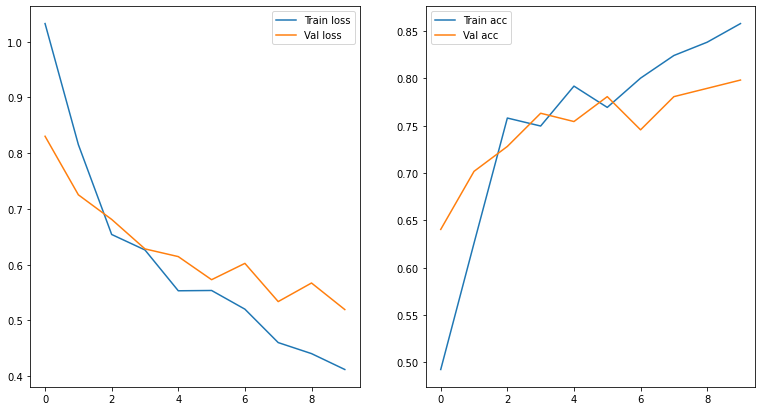

In [12]:
bar_plotting(history)